In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from glob import glob
import sys
import random
from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
#from sklearn.metrics import jaccard_similarity_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable
from dataset import TruckDataset
from utils import list_ids,train_ds,shuffle,normalize_reshape,show_sample
import matplotlib.pyplot as plt
from model import Unet

In [5]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'test_dataset/train'
path_test = 'test_dataset/test'

train_path_images = os.path.abspath(path_train + "/images/")
train_path_masks = os.path.abspath(path_train + "/masks/")

test_path_images = os.path.abspath(path_test + "/images/")
test_path_masks = os.path.abspath(path_test + "/masks/")


In [6]:
train_path_images_list = glob(os.path.join(train_path_images, "*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "*.png"))

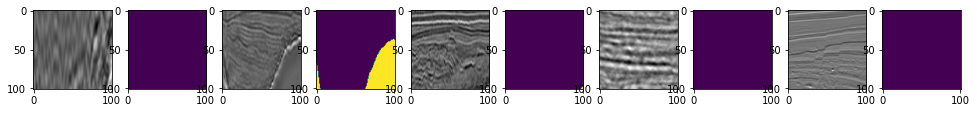

In [7]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
show_sample(ids,train_path_images,train_path_masks)

In [14]:
train_ids = list_ids(train_path_images)
X_train, Y_train = train_ds(path_train,train_ids,im_height = 128,im_width = 128,im_chan=1)

Getting and resizing train images and masks ... 



Done!


In [24]:
X_train_shaped, Y_train_shaped = normalize_reshape(X_train, Y_train)
train_idxs, val_idxs = shuffle(X_train_shaped, val_size = 0.1)
truck_ID_dataset_train = TruckDataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
truck_ID_dataset_val = TruckDataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset=truck_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=truck_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [27]:
model = Unet()
model

Unet(
  (double_conv1): double_conv(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv2): double_conv(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

In [ ]:
model = Unet()
criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
mean_train_losses = []
mean_val_losses = []
for epoch in range(12):
    train_losses = []
    val_losses = []
    for images, masks in train_loader:        
        images = Variable(images)
        masks = Variable(masks)
        
        outputs = model(images)        
        
        loss = criterion(outputs, masks)
        train_losses.append(loss.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, masks in val_loader:
        images = Variable(images)
        masks = Variable(masks)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.data)
    
    mean_train_losses.append(np.mean(train_losses))
    mean_val_losses.append(np.mean(val_losses))
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))

Epoch: 1. Train Loss: 0.41167622804641724. Val Loss: 0.3827418088912964


In [ ]:
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()